In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta


import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
data = pd.read_csv('burglaries_preprocessed.csv')
data = data[['Month', 'Ward']]#, 'Season']]

In [3]:
data

,Month,Ward
0,2010-12,High Barnet
1,2010-12,High Barnet
2,2010-12,High Barnet
3,2010-12,High Barnet
4,2010-12,High Barnet
...,...,...
42986,2023-03,Childs Hill
42987,2023-03,Childs Hill
42988,2023-03,Childs Hill
42989,2023-03,Childs Hill


In [4]:
def reg_evaluation(y_test, y_pred, ward: str):    
    print(f'Results for {ward}:')
    print('Mean Absolute Error:', round(mean_absolute_error(y_test, y_pred),2))
    print('Root Mean Squared Error:', round(np.sqrt(mean_squared_error(y_test, y_pred)),2))
#     print('R2 score:', round(r2_score(y_test, y_pred),2))
    print('Weighted mean absolute percentage error:', 
          round(np.abs(y_test - y_pred).sum() / np.abs(y_test).sum(),2))
    print('\n')

### Fix the imputation below after adding features!!

In [5]:
def create_features(df):
    '''set index to datetime, create temporal features
    '''

    df = df.set_index('Month')
    df.index = pd.to_datetime(df.index)
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['crime_count'] = 1
    
    return df

data = create_features(data)

In [6]:
def return_year_month(row): 
    '''created for convenience later on
    '''
    return str(row['year']) + '-' + str(row['month'])

In [7]:
data

,Ward,month,year,crime_count
Month,,,,
2010-12-01,High Barnet,12,2010,1
2010-12-01,High Barnet,12,2010,1
2010-12-01,High Barnet,12,2010,1
2010-12-01,High Barnet,12,2010,1
2010-12-01,High Barnet,12,2010,1
...,...,...,...,...
2023-03-01,Childs Hill,3,2023,1
2023-03-01,Childs Hill,3,2023,1
2023-03-01,Childs Hill,3,2023,1


In [8]:
data_aggr = data.groupby(['year', 'month', 'Ward']).count()
data_aggr.reset_index(inplace=True)

# aggregate to get crimes per month, per ward in each row

In [9]:
data_aggr.loc[450:500]

,year,month,Ward,crime_count
450,2012,6,Totteridge & Woodside,12
451,2012,6,Underhill,21
452,2012,6,West Finchley,23
453,2012,6,West Hendon,16
454,2012,6,Whetstone,19
455,2012,6,Woodhouse,27
456,2012,7,Barnet Vale,12
457,2012,7,Brunswick Park,10
458,2012,7,Burnt Oak,19
459,2012,7,Childs Hill,26


In [10]:
data_aggr['year_month'] = data_aggr.apply(return_year_month, axis=1)
data_aggr['date'] = data_aggr['year_month']
data_aggr = data_aggr.set_index('date')
data_aggr.index = pd.to_datetime(data_aggr.index)

In [11]:
data_aggr

,year,month,Ward,crime_count,year_month
date,,,,,
2010-12-01,2010,12,Barnet Vale,13,2010-12
2010-12-01,2010,12,Brunswick Park,13,2010-12
2010-12-01,2010,12,Burnt Oak,9,2010-12
2010-12-01,2010,12,Childs Hill,17,2010-12
2010-12-01,2010,12,Colindale North,7,2010-12
...,...,...,...,...,...
2023-03-01,2023,3,Underhill,1,2023-3
2023-03-01,2023,3,West Finchley,13,2023-3
2023-03-01,2023,3,West Hendon,9,2023-3


# Imputation of months w/o crime data

In [12]:
# collect the wards with a missing month

wards_wo_month = []

for month in data_aggr['Ward'].unique():
    if data_aggr[data_aggr['Ward']==month].shape[0]<148:        
        wards_wo_month.append(month)

In [13]:
# get the missing month for each of the wards

all_months = data_aggr.index.unique().to_list()
dct_impute = {}

for ward in wards_wo_month:
    
    lst_months=[]
    
    for i, row in data_aggr[data_aggr['Ward']==ward].iterrows():
        lst_months.append(i)
        dct_impute[ward] = list(set(all_months) - set(lst_months))[0]


In [14]:
dct_impute

{'Colindale North': Timestamp('2014-12-01 00:00:00'),
 'Colindale South': Timestamp('2016-10-01 00:00:00'),
 'Edgwarebury': Timestamp('2021-07-01 00:00:00'),
 'High Barnet': Timestamp('2022-12-01 00:00:00'),
 'Totteridge & Woodside': Timestamp('2021-05-01 00:00:00'),
 'Whetstone': Timestamp('2023-01-01 00:00:00'),
 'Woodhouse': Timestamp('2020-08-01 00:00:00')}

In [15]:
data_aggr.to_csv('data_aggregated.csv')

# Adjust cell to match changes in features!


In [16]:
# imputing all values for the missing months

data_aggr = data_aggr.append(pd.DataFrame({'year':2014, 'month':12, 'Ward':'Colindale North',# 'Season':'Winter', 
                               'crime_count':round(data_aggr[data_aggr['Ward']=='Colindale North']['crime_count'].mean()), 
                                           'year_month':'2014-12'}, index=[dct_impute['Colindale North']]))

data_aggr = data_aggr.append(pd.DataFrame({'year':2016, 'month':10, 'Ward':'Colindale South',# 'Season':'Autumn', 
                               'crime_count':round(data_aggr[data_aggr['Ward']=='Colindale South']['crime_count'].mean()), 
                                           'year_month':'2016-10'}, index=[dct_impute['Colindale South']]))

data_aggr = data_aggr.append(pd.DataFrame({'year':2021, 'month':7, 'Ward':'Edgwarebury',# 'Season':'Summer', 
                               'crime_count':round(data_aggr[data_aggr['Ward']=='Edgwarebury']['crime_count'].mean()), 
                                           'year_month':'2021-7'}, index=[dct_impute['Edgwarebury']]))

data_aggr = data_aggr.append(pd.DataFrame({'year':2022, 'month':12, 'Ward':'High Barnet',# 'Season':'Winter', 
                               'crime_count':round(data_aggr[data_aggr['Ward']=='High Barnet']['crime_count'].mean()), 
                                           'year_month':'2022-12'}, index=[dct_impute['High Barnet']]))

data_aggr = data_aggr.append(pd.DataFrame({'year':2021, 'month':5, 'Ward':'Totteridge & Woodside',# 'Season':'Spring', 
                               'crime_count':round(data_aggr[data_aggr['Ward']=='Totteridge & Woodside']['crime_count'].mean()), 
                                           'year_month':'2021-5'}, index=[dct_impute['Totteridge & Woodside']]))

data_aggr = data_aggr.append(pd.DataFrame({'year':2023, 'month':1, 'Ward':'Whetstone',# 'Season':'January', 
                               'crime_count':round(data_aggr[data_aggr['Ward']=='Whetstone']['crime_count'].mean()), 
                                           'year_month':'2023-1'}, index=[dct_impute['Whetstone']]))

data_aggr = data_aggr.append(pd.DataFrame({'year':2020, 'month':8, 'Ward':'Woodhouse',# 'Season':'Summer', 
                               'crime_count':round(data_aggr[data_aggr['Ward']=='Woodhouse']['crime_count'].mean()), 
                                           'year_month':'2020-8'}, index=[dct_impute['Woodhouse']]))

In [17]:
data_aggr['timestamp']=data_aggr.index
data_aggr.sort_index(inplace=True)

In [37]:
print('Mean burglary count per month in Barnet:', data_aggr.crime_count.mean())

Mean burglary count per month in Barnet: 12.119932432432432


# XGBoost


In [19]:
def data_split_1_ward(data, ward, end_train, end_val):
    '''A single model can only handle the time series of a single ward
       This function prepares the data to train a model on a single ward
    ''' 
    
    FEATURES = ['month']
    TARGET = 'crime_count'
    
    WARD = ward
    data_1w = data[data['Ward']==WARD]
    
    train_1w = data_1w.loc[data_1w.index < end_train]
    val_1w = data_1w.loc[(data_1w.index >= end_train) & (data_1w.index < end_val)]
    test_1w = data_1w.loc[data_1w.index >= end_val]
    
    X_train_1w = train_1w[FEATURES]
    y_train_1w = train_1w[TARGET]

    X_val_1w = val_1w[FEATURES]
    y_val_1w = val_1w[TARGET]

    X_test_1w = test_1w[FEATURES]
    y_test_1w = test_1w[TARGET]
    
    return X_train_1w, X_val_1w, X_test_1w, y_train_1w, y_val_1w, y_test_1w

In [20]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=15000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=10,
                       learning_rate=0.0001)

In [21]:
mae = 0
rmse = 0
r2 = 0
wmape = 0

for ward in data_aggr['Ward'].unique():
    
    X_train_1w, X_val_1w, X_test_1w, y_train_1w, y_val_1w, y_test_1w = data_split_1_ward(
    data_aggr, ward, '2022-01-01', '2022-08-01')

    reg.fit(X_train_1w, y_train_1w, eval_set=[(X_val_1w, y_val_1w)], verbose=200)
    
    reg_evaluation(y_test_1w, reg.predict(X_test_1w), ward)
    
    mae += mean_absolute_error(y_test_1w, reg.predict(X_test_1w))
    rmse += mean_squared_error(y_test_1w, reg.predict(X_test_1w))
    r2 += r2_score(y_test_1w, reg.predict(X_test_1w))
    wmape += np.abs(y_test_1w - reg.predict(X_test_1w)).sum() / np.abs(y_test_1w).sum()
    
mae /= 24
rmse /= 24
rmse = np.sqrt(rmse)
r2 /= 24
wmape /= 24

[00:55:49] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:6.47690
[200]	validation_0-rmse:6.26329
[400]	validation_0-rmse:6.05553
[600]	validation_0-rmse:5.85360
[800]	validation_0-rmse:5.65648
[1000]	validation_0-rmse:5.46362
[1200]	validation_0-rmse:5.27671
[1400]	validation_0-rmse:5.09579
[1600]	validation_0-rmse:4.92093
[1800]	validation_0-rmse:4.75212
[2000]	validation_0-rmse:4.58946
[2200]	validation_0-rmse:4.43328
[2400]	validation_0-rmse:4.28489
[2600]	validation_0-rmse:4.14283
[2800]	validation_0-rmse:4.00717
[3000]	validation_0-rmse:3.87803
[3200]	validation_0-rmse:3.75552
[3400]	validation_0-rmse:3.63974
[3600]	validation_0-rmse:3.53082
[3800]	validation_0-rmse:3.42886
[4000]	validation_0-rmse:3.33397
[4200]	validation_0-rmse:3.24625
[4400]	validation_0-rmse:3.16577
[4600]	validation_0-rmse:3.09260
[4800]	validation_0-rmse:3.02631
[5000

[6400]	validation_0-rmse:2.77280
[6600]	validation_0-rmse:2.69262
[6800]	validation_0-rmse:2.62150
[7000]	validation_0-rmse:2.55958
[7200]	validation_0-rmse:2.50694
[7400]	validation_0-rmse:2.46360
[7600]	validation_0-rmse:2.42948
[7800]	validation_0-rmse:2.40442
[8000]	validation_0-rmse:2.38818
[8200]	validation_0-rmse:2.38044
[8341]	validation_0-rmse:2.37987
Results for West Finchley:
Mean Absolute Error: 3.73
Root Mean Squared Error: 4.27
Weighted mean absolute percentage error: 0.32


[00:56:44] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:2.92099
[200]	validation_0-rmse:2.80301
[400]	validation_0-rmse:2.69137
[600]	validation_0-rmse:2.58627
[800]	validation_0-rmse:2.49489
[1000]	validation_0-rmse:2.42121
[1200]	validation_0-rmse:2.35509
[1400]	validation_0-rmse:2.29665
[1600]	validation_0-rmse:2.24600
[1800]	validation_0-rmse:2.20315
[2000]

[200]	validation_0-rmse:9.14085
[400]	validation_0-rmse:8.89503
[600]	validation_0-rmse:8.65537
[800]	validation_0-rmse:8.42179
[1000]	validation_0-rmse:8.19424
[1200]	validation_0-rmse:7.97268
[1400]	validation_0-rmse:7.75705
[1600]	validation_0-rmse:7.54731
[1800]	validation_0-rmse:7.34342
[2000]	validation_0-rmse:7.14535
[2200]	validation_0-rmse:6.95307
[2400]	validation_0-rmse:6.76654
[2600]	validation_0-rmse:6.58575
[2800]	validation_0-rmse:6.41068
[3000]	validation_0-rmse:6.24130
[3200]	validation_0-rmse:6.07761
[3400]	validation_0-rmse:5.91959
[3600]	validation_0-rmse:5.76694
[3800]	validation_0-rmse:5.61991
[4000]	validation_0-rmse:5.47855
[4200]	validation_0-rmse:5.34288
[4400]	validation_0-rmse:5.21287
[4600]	validation_0-rmse:5.08854
[4800]	validation_0-rmse:4.96988
[5000]	validation_0-rmse:4.85688
[5200]	validation_0-rmse:4.74954
[5400]	validation_0-rmse:4.64785
[5600]	validation_0-rmse:4.55180
[5800]	validation_0-rmse:4.46136
[6000]	validation_0-rmse:4.37650
[6200]	validat

[3600]	validation_0-rmse:1.84900
[3800]	validation_0-rmse:1.80121
[4000]	validation_0-rmse:1.75895
[4200]	validation_0-rmse:1.72227
[4400]	validation_0-rmse:1.69118
[4600]	validation_0-rmse:1.66563
[4800]	validation_0-rmse:1.64556
[5000]	validation_0-rmse:1.63085
[5200]	validation_0-rmse:1.62132
[5400]	validation_0-rmse:1.61679
[5539]	validation_0-rmse:1.61645
Results for Edgwarebury:
Mean Absolute Error: 1.3
Root Mean Squared Error: 1.46
Weighted mean absolute percentage error: 0.36


[00:58:32] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:11.85375
[200]	validation_0-rmse:11.65004
[400]	validation_0-rmse:11.45049
[600]	validation_0-rmse:11.25501
[800]	validation_0-rmse:11.06221
[1000]	validation_0-rmse:10.87306
[1200]	validation_0-rmse:10.68773
[1400]	validation_0-rmse:10.50612
[1600]	validation_0-rmse:10.32818
[1800]	validation_0-rmse:10.15381

[4600]	validation_0-rmse:4.16954
[4800]	validation_0-rmse:4.07338
[5000]	validation_0-rmse:3.98048
[5200]	validation_0-rmse:3.89083
[5400]	validation_0-rmse:3.80440
[5600]	validation_0-rmse:3.72117
[5800]	validation_0-rmse:3.64112
[6000]	validation_0-rmse:3.56423
[6200]	validation_0-rmse:3.49047
[6400]	validation_0-rmse:3.41983
[6600]	validation_0-rmse:3.35228
[6800]	validation_0-rmse:3.28780
[7000]	validation_0-rmse:3.22636
[7200]	validation_0-rmse:3.16793
[7400]	validation_0-rmse:3.11248
[7600]	validation_0-rmse:3.06059
[7800]	validation_0-rmse:3.01196
[8000]	validation_0-rmse:2.96605
[8200]	validation_0-rmse:2.92284
[8400]	validation_0-rmse:2.88228
[8600]	validation_0-rmse:2.84432
[8800]	validation_0-rmse:2.80892
[9000]	validation_0-rmse:2.77603
[9200]	validation_0-rmse:2.74559
[9400]	validation_0-rmse:2.71755
[9600]	validation_0-rmse:2.69186
[9800]	validation_0-rmse:2.66828
[10000]	validation_0-rmse:2.64673
[10200]	validation_0-rmse:2.62740
[10400]	validation_0-rmse:2.61023
[10600]

[5000]	validation_0-rmse:9.45066
[5200]	validation_0-rmse:9.24631
[5400]	validation_0-rmse:9.04780
[5600]	validation_0-rmse:8.85503
[5800]	validation_0-rmse:8.66795
[6000]	validation_0-rmse:8.48650
[6200]	validation_0-rmse:8.31061
[6400]	validation_0-rmse:8.14021
[6600]	validation_0-rmse:7.97524
[6800]	validation_0-rmse:7.81529
[7000]	validation_0-rmse:7.65995
[7200]	validation_0-rmse:7.50990
[7400]	validation_0-rmse:7.36510
[7600]	validation_0-rmse:7.22547
[7800]	validation_0-rmse:7.09095
[8000]	validation_0-rmse:6.96150
[8200]	validation_0-rmse:6.83704
[8400]	validation_0-rmse:6.72144
[8600]	validation_0-rmse:6.61572
[8800]	validation_0-rmse:6.51498
[9000]	validation_0-rmse:6.41967
[9200]	validation_0-rmse:6.33374
[9400]	validation_0-rmse:6.25438
[9600]	validation_0-rmse:6.17905
[9800]	validation_0-rmse:6.10802
[10000]	validation_0-rmse:6.04108
[10200]	validation_0-rmse:5.97835
[10400]	validation_0-rmse:5.91961
[10600]	validation_0-rmse:5.86477
[10800]	validation_0-rmse:5.81363
[1100

In [22]:
print('Metrics for XGB w/o MLForecast')
print('MAE:', mae)
print('RMSE:', rmse)
print('WMAPE:', wmape)
# print('R2:', r2)

Metrics for XGB w/o MLForecast
MAE: 3.0697665909926095
RMSE: 3.941328990432361
WMAPE: 0.3480948173694325


### Split data for DeepAR and XGB w/ MLForecast


In [47]:
train = data_aggr.loc[(data_aggr.index >= '2010-03-01') & (data_aggr.index < '2022-03-01')]
train2 = data_aggr.loc[(data_aggr.index >= '2020-03-01') & (data_aggr.index < '2022-03-01')]
val = data_aggr.loc[data_aggr.index >= '2022-03-01']

## XGB with MLForecast (unfinished)

In [48]:
dct_idx = dict(zip(list(val['year_month'].unique()), [i for i in range(1, len(val['year_month'].unique())+1)]))
val_MLF = val.replace({"year_month": dct_idx})

In [49]:
from mlforecast import MLForecast

from window_ops.rolling import rolling_mean, rolling_max, rolling_min


reg2 = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=10000,
                       objective='reg:linear',
                       max_depth=10,
                       learning_rate=0.0001)

model = MLForecast(models=reg2,
                   freq='M',
                   lags=[1, 12],
                   lag_transforms={
                       1: [(rolling_mean, 3), (rolling_max, 3), (rolling_min, 3)],},
                   num_threads=4)


model.fit(train2[['month','crime_count','Ward']], id_col='Ward', time_col='month', target_col='crime_count', 
        static_features=[])

C:\Users\Goshko\anaconda3\lib\site-packages\mlforecast\core.py:218: UserWarning: Setting `freq=1` since time col is int.
  warnings.warn("Setting `freq=1` since time col is int.")


[01:27:45] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.


MLForecast(models=[XGBRegressor], freq=1, lag_features=['lag1', 'lag12', 'rolling_mean_lag1_window_size3', 'rolling_max_lag1_window_size3', 'rolling_min_lag1_window_size3'], date_features=[], num_threads=4)

In [50]:
# collecting predictions 

p = model.predict(horizon=val_MLF['timestamp'].nunique())
p['year_month'] = p['month']
p.drop(columns=['month'], inplace=True)
p['year_month'] = p['year_month']-12
p = p.merge(val_MLF[['Ward', 'timestamp', 'year_month', 'crime_count']], on=['Ward', 'year_month'], how='left')

In [51]:
p[['Ward', 'XGBRegressor', 'crime_count', 'timestamp']].loc[52:64]

,Ward,XGBRegressor,crime_count,timestamp
52,Colindale North,3.661759,6,2022-03-01
53,Colindale North,3.150340,4,2022-04-01
54,Colindale North,4.290215,4,2022-05-01
55,Colindale North,4.228911,3,2022-06-01
56,Colindale North,6.698258,8,2022-07-01
57,Colindale North,4.092427,4,2022-08-01
58,Colindale North,6.528521,6,2022-09-01
59,Colindale North,3.343265,4,2022-10-01
60,Colindale North,4.214192,5,2022-11-01
61,Colindale North,4.788652,6,2022-12-01


# DeepAR

In [52]:
def wmape(y_true, y_pred):
    '''Weighted Mean Absolute Percentage Error
    '''
    
    return np.abs(y_true - y_pred).sum() / np.abs(y_true).sum()

In [75]:
from gluonts.dataset.pandas import PandasDataset

train_ds = PandasDataset.from_long_dataframe(train, target='crime_count', item_id='Ward', 
                                       timestamp='year_month', freq='M')

In [113]:
from gluonts.torch.model.deepar import DeepAREstimator

estimator = DeepAREstimator(freq='M', prediction_length=6, num_layers=3, lr=0.0005, context_length=24,
                            trainer_kwargs={'max_epochs':6})

predictor = estimator.train(train_ds, num_workers=4)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\Goshko\anaconda3\lib\site-packages\pytorch_lightning\trainer\configuration_validator.py:110: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  category=PossibleUserWarning,

  | Name  | Type        | Params | In sizes | Out sizes  
---------------------------------------------------------------
0 | model | DeepARModel | 36.4 K | ?        | [1, 100, 6]
---------------------------------------------------------------
36.4 K    Trainable params
0         Non-trainable params
36.4 K    Total params
0.146     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Epoch 0, global step 50: 'train_loss' reached 3.34050 (best 3.34050), saving model to 'C:\\Users\\Goshko\\Desktop\\DC 2\\JBG050-Group-3\\lightning_logs\\version_73\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 2.85648 (best 2.85648), saving model to 'C:\\Users\\Goshko\\Desktop\\DC 2\\JBG050-Group-3\\lightning_logs\\version_73\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 2.80591 (best 2.80591), saving model to 'C:\\Users\\Goshko\\Desktop\\DC 2\\JBG050-Group-3\\lightning_logs\\version_73\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' was not in top 1
Epoch 4, global step 250: 'train_loss' reached 2.77094 (best 2.77094), saving model to 'C:\\Users\\Goshko\\Desktop\\DC 2\\JBG050-Group-3\\lightning_logs\\version_73\\checkpoints\\epoch=4-step=250.ckpt' as top 1
Epoch 5, global step 300: 'train_loss' reached 2.74367 (best 2.74367), saving model to 'C:\\Users\\Gos

In [114]:
# collect predictions

pred = list(predictor.predict(train_ds))
all_preds = list()
for ward in pred:
    ward_name = ward.item_id
    p = ward.samples.mean(axis=0)
    p10 = np.percentile(ward.samples, 10, axis=0)
    # making an 80% confidence interval
    p90 = np.percentile(ward.samples, 90, axis=0)
    dates = pd.date_range(start=ward.start_date.to_timestamp(), periods=len(p), freq='M')
    ward_pred = pd.DataFrame({'timestamp-1': dates, 'Ward': ward_name, 'pred': p, 'p10': p10, 'p90': p90})
    ward_pred['timestamp']  = ward_pred['timestamp-1'] + timedelta(days=1)
    all_preds += [ward_pred]

all_preds = pd.concat(all_preds, ignore_index=True)
all_preds = all_preds.merge(val, on=['timestamp', 'Ward'], how='left')

In [115]:
wmape(all_preds['crime_count'], all_preds['pred'])

0.30915030985013814

In [116]:
reg_evaluation(all_preds['crime_count'], all_preds['pred'], 'all wards')

Results for all wards:
Mean Absolute Error: 2.42
Root Mean Squared Error: 3.26
Weighted mean absolute percentage error: 0.31




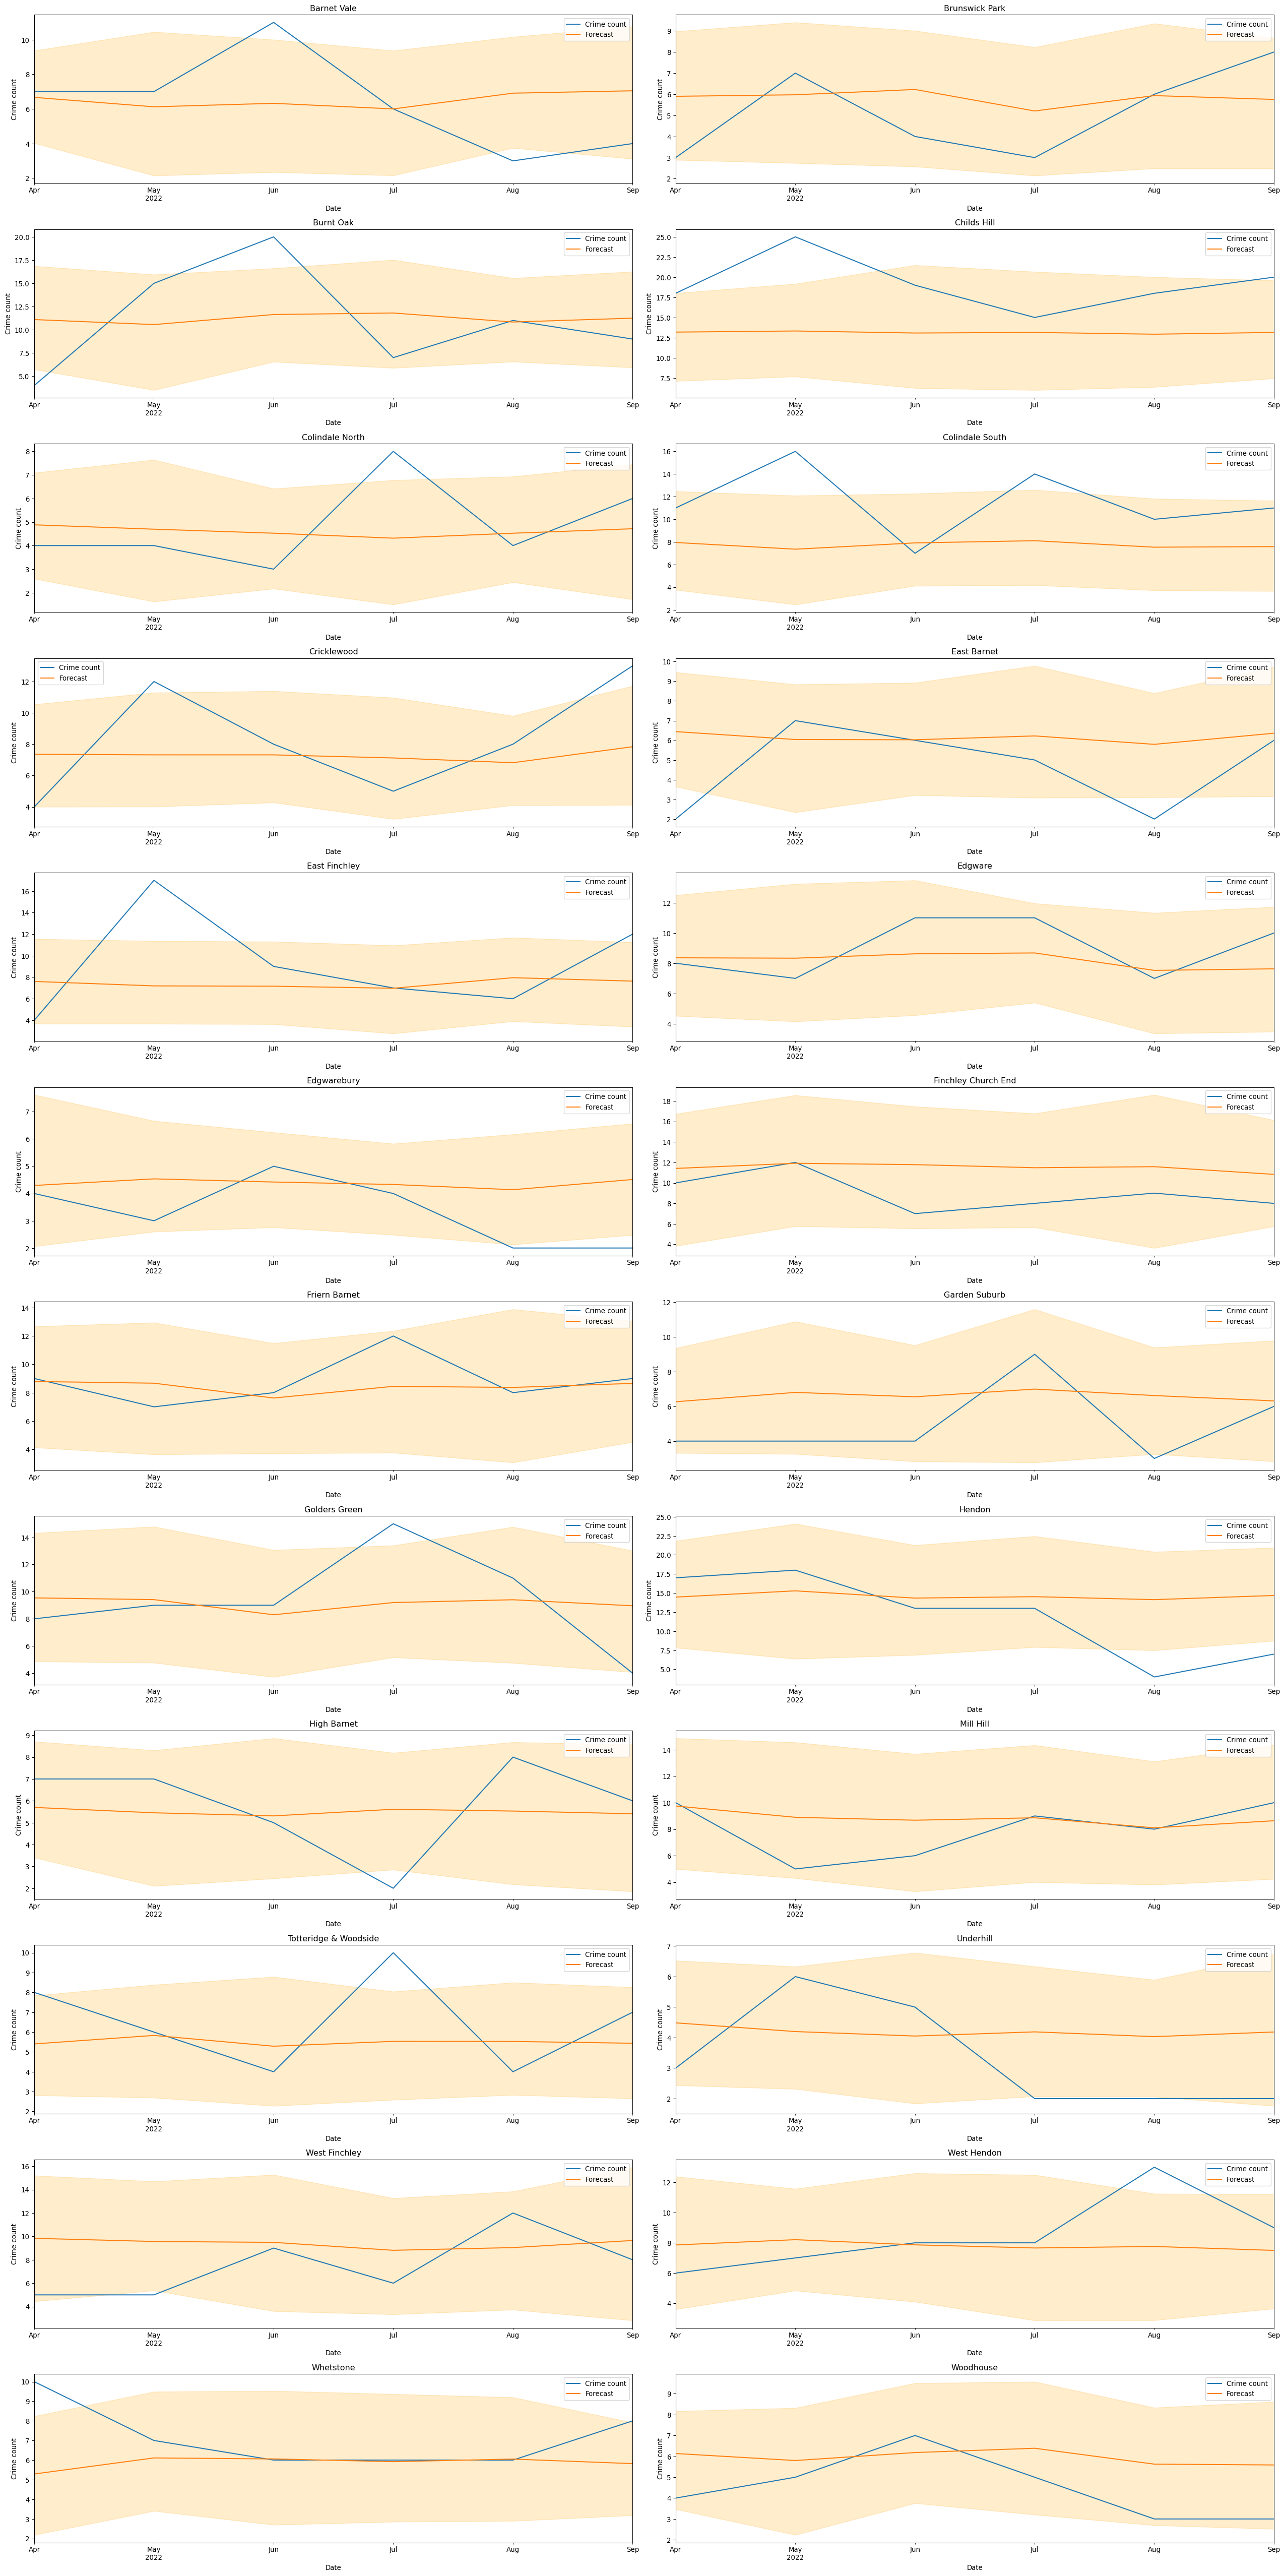

In [117]:
fig, ax = plt.subplots(12,2, figsize=(2*1280/96, 4*1280/96), dpi=96)
ax = ax.flatten()

for ax_ ,ward in enumerate(all_preds['Ward'].unique()):
    p_ = all_preds.loc[all_preds['Ward'] == ward]
    p_.plot(x='timestamp', y='crime_count', ax=ax[ax_], label='Crime count')
    p_.plot(x='timestamp', y='pred', ax=ax[ax_], label='Forecast')
    ax[ax_].fill_between(p_['timestamp'].values, p_['p10'], p_['p90'], alpha=0.2, color='orange')
    ax[ax_].set_title(ward)
    ax[ax_].legend()
    ax[ax_].set_xlabel('Date')
    ax[ax_].set_ylabel('Crime count')
    
fig.tight_layout()